## Mount drive & import

In [ ]:
from google.colab import drive
# drive.mount('/content/drive/MyDrive/IITP/sohyun/creditcard_prediction/data')
drive.mount('/content/drive')

%cd drive/MyDrive/IITP/sohyun/TimeSeriesAnomaly/data/modify

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1j1N0u5t0l99N_wfSd5UZvnhugzn5g_NC/TimeSeriesAnomaly/data/modify


In [ ]:
# !pip install wandb -qqq
# import wandb
# wandb.login()

In [ ]:
import matplotlib.pyplot as plt
import easydict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import time
import math

import seaborn as sns
from pylab import rcParams
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics
import copy

## Data 

In [ ]:
#---# LOAD npy file #---#
Fu_20_normal = np.load('Fu_20_normal.npy')
Fu_21_normal = np.load('Fu_21_normal.npy')
Fu_21_abnormal = np.load('Fu_21_abnormal.npy')
Fu_22_normal = np.load('Fu_22_normal.npy')
Fu_22_abnormal = np.load('Fu_22_abnormal.npy')

Fu_20_normal_10 = np.load('Fu_20_normal_10.npy')
Fu_21_normal_10 = np.load('Fu_21_normal_10.npy')
Fu_21_abnormal_10 = np.load('Fu_21_abnormal_10.npy')
Fu_22_normal_10 = np.load('Fu_22_normal_10.npy')
Fu_22_abnormal_10 = np.load('Fu_22_abnormal_10.npy')

# import sys
# np.set_printoptions(threshold=sys.maxsize) # print all

#---# 확인용 #---#
# plt.figure(figsize=(30,5))
# plt.plot(Fu_22_abnormal_10)

Dataset

In [ ]:
class MyDataset(Dataset):
  def __init__(self, config, mode="train"):
    # 최종 목표 : path
    # self.data_path_list = data_path_list
    # self.data_list = [_load_data() for data_path in self.data_path_list] 
    self.mode = mode
    self.config = config
    self.device = self.config.device
    self.train_list = [Fu_22_normal_10, Fu_21_normal_10, Fu_20_normal_10]
    self.test_list = [Fu_22_abnormal_10]
    
    # scaling
    self.scaled_train_list, self.scaled_test = self._scale()
    
    # sliding window & concat
    self.slided_train_list = [self._sliding_window(data) for data in self.scaled_train_list]
    self.train = np.concatenate(self.slided_train_list, axis=0)
    
    # split
    y = [0 for _ in range(len(self.train))]
    self.x_train, self.x_val, _, _ = train_test_split(self.train, y, test_size=0.2, random_state=self.config.seed)
    self.x_test = self._sliding_window(self.scaled_test)
    
  def __getitem__(self, index):
    if self.mode == "train":
      self.x = self.x_train[index]
    elif self.mode == "test":
      self.x = self.x_test[index]
    elif self.mode == "val":
      self.x = self.x_val[index]
    return torch.tensor(self.x, dtype=torch.float32)
      
  def __len__(self):
    if self.mode == "train":
      self.x = self.x_train
    elif self.mode == "test":
      self.x = self.x_test
    elif self.mode == "val":
      self.x = self.x_val
    return len(self.x)
      
  def _scale(self):
    '''
    input
    output
    '''
    train = np.concatenate(self.train_list, axis=0)
    test = self.test_list[0]
    total = np.concatenate([train, test])

    scaler = StandardScaler()
    total_scaled = scaler.fit_transform(total.reshape(-1, 1)).squeeze()
    train_scaled = scaler.transform(train.reshape(-1,1)).squeeze()
    test_scaled = scaler.transform(test.reshape(-1,1)).squeeze()

    train_list = []
    split_idx1, split_idx2 = len(self.train_list[0]), len(self.train_list[1]) 

    train_list.append(train_scaled[:split_idx1])
    train_list.append(train_scaled[split_idx1:split_idx1+split_idx2])
    train_list.append(train_scaled[split_idx1+split_idx2:])

    return train_list, test_scaled

  def _sliding_window(self, arr):
    start_pt = 0
    total_data = []
    while(True):
      if len(arr) < (start_pt + config.window_size) : break
      data = arr[start_pt:start_pt + config.window_size]
      start_pt += config.stride
      total_data.append(data)
    return np.array(total_data)


## Functions

In [ ]:
from pandas.core.arrays.sparse import array
def seed_everything(seed: int = 42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)  # type: ignore
  torch.backends.cudnn.deterministic = True  # type: ignore
  torch.backends.cudnn.benchmark = True  # type: ignore

def get_anomaly_time(original, prediction) : 
  temp = np.zeros(shape=(len(original),), dtype=np.float32)
  # original = original.squeeze(axis = 1)

  for i in range(len(prediction)) :
    if prediction[i] == 0 :
      temp[i*config.stride : (i*config.stride + config.window_size)] = np.nan

    elif prediction[i] == 1 : # anomaly
      temp[i*config.stride : (i*config.stride + config.window_size)] = original[i*config.stride : (i*config.stride + config.window_size)]

  return temp

def drawing(pred, x) :
  #---# Drawing - 22 #---#
  plt.figure(figsize=(30,5))
  plt.plot(x, markersize=1)
  plt.plot(pred, marker='.', markersize=2, color='r', linestyle='None')

  #---# 실제 anomaly 값 구간 #---#
  a = np.linspace(62200, 65300)
  # plt.fill_between(a, 0, 2000, color='green', alpha=0.3)
  plt.fill_between(a, -1, 4, color='green', alpha=0.5)
  b = np.linspace(95600, 99300)
  # plt.fill_between(b, 0, 2000, color='green', alpha=0.5)
  plt.fill_between(b, -1, 4, color='green', alpha=0.5)
  c = np.linspace(148400, 152300)
  # plt.fill_between(c, 0, 2000, color='green', alpha=0.5)
  plt.fill_between(c, -1, 4, color='green', alpha=0.5)

  plt.show()
  plt.clf()

def calculate(true_list, pred_list): 
  pred_list = pred_list.dropna()

  pred_anomaly_set = set(pred_list.index.tolist())
  pred_normal_set = set(range(len(true_list))) - pred_anomaly_set
  true_anomaly_set = set(np.where(np.array(true_list) != 0)[0].tolist())
  true_normal_set = set(np.where(np.array(true_list) == 0)[0].tolist())

  recall = len(pred_anomaly_set.intersection(true_anomaly_set)) / len(true_anomaly_set)
  precision = len(pred_anomaly_set.intersection(true_anomaly_set)) / len(pred_anomaly_set.union(true_anomaly_set)) # len(anomaly_set.union(true_set))
  accuracy = (len(pred_anomaly_set.intersection(true_anomaly_set)) + len(pred_normal_set.intersection(true_normal_set))) / len(true_list) # (빨간 거 맞은거 + 파란거 맞은거) / 전체
  return recall, precision, accuracy

def get_true_label(test_dataset):
  ##########################
  #---# true list 만들기 #---#
  ##########################
  true_label = [0 for i in range(len(test_dataset.scaled_test))] # test_scale
  true_label[62200:65300] = [1 for i in range(62200,65300)]
  true_label[95600:99300] = [1 for i in range(95600,99300)]
  true_label[148400:152300] = [1 for i in range(148400,152300)]

  # true_label_sliding = sliding_window(np.array(true_label), config.window_size, config.stride)
  # true_label_sliding = np.expand_dims(np.array(true_label_sliding), 2) # dimension expansion
  return true_label


Reconstruction error

In [ ]:
"""
Time Series error calculation functions.
"""

import math
import numpy as np
import pandas as pd
# from pyts.metrics import dtw
from scipy import integrate


def regression_errors(y, y_hat, smoothing_window=0.01, smooth=True):
  """Compute an array of absolute errors comparing predictions and expected output.
  If smooth is True, apply EWMA to the resulting array of errors.
  Args:
    y (ndarray):
      Ground truth.
    y_hat (ndarray):
      Predicted values.
    smoothing_window (float):
      Optional. Size of the smoothing window, expressed as a proportion of the total
      length of y. If not given, 0.01 is used.
    smooth (bool):
      Optional. Indicates whether the returned errors should be smoothed with EWMA.
      If not given, `True` is used.
  Returns:
    ndarray:
      Array of errors.
  """
  errors = np.abs(y - y_hat)[:, 0]

  if not smooth:
    return errors

  smoothing_window = int(smoothing_window * len(y))

  return pd.Series(errors).ewm(span=smoothing_window).mean().values


def _point_wise_error(y, y_hat):
  """Compute point-wise error between predicted and expected values.
  The computed error is calculated as the difference between predicted
  and expected values with a rolling smoothing factor.
  Args:
    y (ndarray):
      Ground truth.
    y_hat (ndarray):
      Predicted values.
  Returns:
    ndarray:
      An array of smoothed point-wise error.
  """
  return abs(y - y_hat)


def _area_error(y, y_hat, score_window=10):
  """Compute area error between predicted and expected values.
  The computed error is calculated as the area difference between predicted
  and expected values with a smoothing factor.
  Args:
    y (ndarray):
      Ground truth.
    y_hat (ndarray):
      Predicted values.
    score_window (int):
      Optional. Size of the window over which the scores are calculated.
      If not given, 10 is used.
  Returns:
    ndarray:
      An array of area error.
  """
  smooth_y = pd.Series(y).rolling(
      score_window, center=True, min_periods=score_window // 2).apply(integrate.trapz)
  smooth_y_hat = pd.Series(y_hat).rolling(
      score_window, center=True, min_periods=score_window // 2).apply(integrate.trapz)

  errors = abs(smooth_y - smooth_y_hat)

  return errors


def _dtw_error(y, y_hat, score_window=10):
  """Compute dtw error between predicted and expected values.
  The computed error is calculated as the dynamic time warping distance
  between predicted and expected values with a smoothing factor.
  Args:
    y (ndarray):
      Ground truth.
    y_hat (ndarray):
      Predicted values.
    score_window (int):
      Optional. Size of the window over which the scores are calculated.
      If not given, 10 is used.
  Returns:
    ndarray:
      An array of dtw error.
  """
  length_dtw = (score_window // 2) * 2 + 1
  half_length_dtw = length_dtw // 2

  # add padding
  y_pad = np.pad(y, (half_length_dtw, half_length_dtw),
                  'constant', constant_values=(0, 0))
  y_hat_pad = np.pad(y_hat, (half_length_dtw, half_length_dtw),
                  'constant', constant_values=(0, 0))

  i = 0
  similarity_dtw = list()
  while i < len(y) - length_dtw:
    true_data = y_pad[i:i + length_dtw]
    true_data = true_data.flatten()

    pred_data = y_hat_pad[i:i + length_dtw]
    pred_data = pred_data.flatten()

    dist = dtw(true_data, pred_data)
    similarity_dtw.append(dist)
    i += 1

  errors = ([0] * half_length_dtw + similarity_dtw +
            [0] * (len(y) - len(similarity_dtw) - half_length_dtw))

  return errors


def reconstruction_errors(y, y_hat, step_size=1, score_window=10, smoothing_window=0.01,
                        smooth=True, rec_error_type='point'):
  """Compute an array of reconstruction errors.
  Compute the discrepancies between the expected and the
  predicted values according to the reconstruction error type.
  Args:
    y (ndarray):
      Ground truth.
    y_hat (ndarray):
      Predicted values. Each timestamp has multiple predictions.
    step_size (int):
      Optional. Indicating the number of steps between windows in the predicted values.
      If not given, 1 is used.
    score_window (int):
      Optional. Size of the window over which the scores are calculated.
      If not given, 10 is used.
    smoothing_window (float or int):
      Optional. Size of the smoothing window, when float it is expressed as a proportion
      of the total length of y. If not given, 0.01 is used.
    smooth (bool):
      Optional. Indicates whether the returned errors should be smoothed.
      If not given, `True` is used.
    rec_error_type (str):
      Optional. Reconstruction error types ``["point", "area", "dtw"]``.
      If not given, "point" is used.
  Returns:
    ndarray:
      Array of reconstruction errors.
  """
  y = y.reshape(y.shape[0], -1, 1) # 추가 부분 y.shape = (932, 1000, 1)
  y_hat = y_hat.reshape(y_hat.shape[0], -1, 1) # 추가 부분 y_hat shape = (932, 1000, 1)
  
  if isinstance(smoothing_window, float):
    smoothing_window = min(math.trunc(len(y) * smoothing_window), 200) # 9
    # len(y) * smoothing_window = 9 (932 * 0.01)

  true = [item[0] for item in y.reshape((y.shape[0], -1))] # 932개

  for item in y[-1][1:]: # y[-1][1] shape : (999,1)
    true.extend(item) # 총 개수 1931
  
  predictions = []
  predictions_vs = []

  pred_length = y_hat.shape[1] # 1000 
  num_errors = y_hat.shape[1] + step_size * (y_hat.shape[0] - 1) # 1931

  for i in range(num_errors): 
    intermediate = []
    for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
      intermediate.append(y_hat[i - j, j])

    if intermediate:
      predictions.append(np.median(np.asarray(intermediate)))

      predictions_vs.append([[
          np.min(np.asarray(intermediate)),
          np.percentile(np.asarray(intermediate), 25),
          np.percentile(np.asarray(intermediate), 50),
          np.percentile(np.asarray(intermediate), 75),
          np.max(np.asarray(intermediate))
      ]])

  true = np.asarray(true)
  predictions = np.asarray(predictions)
  predictions_vs = np.asarray(predictions_vs)

  # Compute reconstruction errors
  if rec_error_type.lower() == "point":
    errors = _point_wise_error(true, predictions)

  elif rec_error_type.lower() == "area":
    errors = _area_error(true, predictions, score_window)

  elif rec_error_type.lower() == "dtw":
    errors = _dtw_error(true, predictions, score_window)

  # Apply smoothing
  if smooth:
    errors = pd.Series(errors).rolling(
      smoothing_window, center=True, min_periods=smoothing_window // 2).mean().values

  return errors, predictions_vs

Find anomaly

In [ ]:
"""
Time Series anomaly detection functions.
Some of the implementation is inspired by the paper https://arxiv.org/pdf/1802.04431.pdf
"""

import numpy as np
import pandas as pd
from scipy.optimize import fmin


def deltas(errors, epsilon, mean, std):
  """Compute mean and std deltas.
  delta_mean = mean(errors) - mean(all errors below epsilon)
  delta_std = std(errors) - std(all errors below epsilon)
  Args:
    errors (ndarray):
      Array of errors.
    epsilon (ndarray):
      Threshold value.
    mean (float):
      Mean of errors.
    std (float):
      Standard deviation of errors.
  Returns:
    float, float:
      * delta_mean.
      * delta_std.
  """
  below = errors[errors <= epsilon]
  if not len(below):
    return 0, 0

  return mean - below.mean(), std - below.std()


def count_above(errors, epsilon):
  """Count number of errors and continuous sequences above epsilon.
  Continuous sequences are counted by shifting and counting the number
  of positions where there was a change and the original value was true,
  which means that a sequence started at that position.
  Args:
    errors (ndarray):
      Array of errors.
    epsilon (ndarray):
      Threshold value.
  Returns:
    int, int:
      * Number of errors above epsilon.
      * Number of continuous sequences above epsilon.
  """
  above = errors > epsilon
  total_above = len(errors[above])

  above = pd.Series(above)
  shift = above.shift(1)
  change = above != shift

  total_consecutive = sum(above & change)

  return total_above, total_consecutive


def z_cost(z, errors, mean, std):
  """Compute how bad a z value is.
  The original formula is::
                (delta_mean/mean) + (delta_std/std)
      ------------------------------------------------------
      number of errors above + (number of sequences above)^2
  which computes the "goodness" of `z`, meaning that the higher the value
  the better the `z`.
  In this case, we return this value inverted (we make it negative), to convert
  it into a cost function, as later on we will use scipy.fmin to minimize it.
  Args:
    z (ndarray):
      Value for which a cost score is calculated.
    errors (ndarray):
      Array of errors.
    mean (float):
      Mean of errors.
    std (float):
      Standard deviation of errors.
  Returns:
    float:
      Cost of z.
  """
  epsilon = mean + z * std

  delta_mean, delta_std = deltas(errors, epsilon, mean, std)
  above, consecutive = count_above(errors, epsilon)

  numerator = -(delta_mean / mean + delta_std / std)
  denominator = above + consecutive ** 2

  if denominator == 0:
    return np.inf

  return numerator / denominator


def _find_threshold(errors, z_range):
  """Find the ideal threshold.
  The ideal threshold is the one that minimizes the z_cost function. Scipy.fmin is used
  to find the minimum, using the values from z_range as starting points.
  Args:
    errors (ndarray):
      Array of errors.
    z_range (list):
      List of two values denoting the range out of which the start points for the
      scipy.fmin function are chosen.
  Returns:
    float:
      Calculated threshold value.
  """
  mean = errors.mean()
  std = errors.std()

  min_z, max_z = z_range
  best_z = min_z
  best_cost = np.inf
  for z in range(min_z, max_z):
    best = fmin(z_cost, z, args=(errors, mean, std), full_output=True, disp=False) # minimize
    z, cost = best[0:2]
 
    if cost < best_cost:
      best_z = z[0]

  return mean + best_z * std


def _fixed_threshold(errors, k=4):
  """Calculate the threshold.
  The fixed threshold is defined as k standard deviations away from the mean.
  Args:
    errors (ndarray):
      Array of errors.
  Returns:
    float:
      Calculated threshold value.
  """
  mean = errors.mean()
  std = errors.std()

  return mean + k * std


def _find_sequences(errors, epsilon, anomaly_padding):
  """Find sequences of values that are above epsilon.
  This is done following this steps:
    * create a boolean mask that indicates which values are above epsilon.
    * mark certain range of errors around True values with a True as well.
    * shift this mask by one place, filing the empty gap with a False.
    * compare the shifted mask with the original one to see if there are changes.
    * Consider a sequence start any point which was true and has changed.
    * Consider a sequence end any point which was false and has changed.
  Args:
    errors (ndarray):
      Array of errors.
    epsilon (float):
      Threshold value. All errors above epsilon are considered an anomaly.
    anomaly_padding (int):
      Number of errors before and after a found anomaly that are added to the
      anomalous sequence.
  Returns:
    ndarray, float:
      * Array containing start, end of each found anomalous sequence.
      * Maximum error value that was not considered an anomaly.
  """
  above = pd.Series(errors > epsilon)
  index_above = np.argwhere(above.values)

  for idx in index_above.flatten():
    above[max(0, idx - anomaly_padding):min(idx + anomaly_padding + 1, len(above))] = True

  shift = above.shift(1).fillna(False)
  change = above != shift

  if above.all():
    max_below = 0
  else:
    max_below = max(errors[~above])

  index = above.index
  starts = index[above & change].tolist()
  ends = (index[~above & change] - 1).tolist()

  if len(ends) == len(starts) - 1:
    ends.append(len(above) - 1)

  return np.array([starts, ends]).T, max_below


def _get_max_errors(errors, sequences, max_below):
  """Get the maximum error for each anomalous sequence.
  Also add a row with the max error which was not considered anomalous.
  Table containing a ``max_error`` column with the maximum error of each
  sequence and the columns ``start`` and ``stop`` with the corresponding start and stop
  indexes, sorted descendingly by the maximum error.
  Args:
    errors (ndarray):
      Array of errors.
    sequences (ndarray):
      Array containing start, end of anomalous sequences
    max_below (float):
      Maximum error value that was not considered an anomaly.
  Returns:
    pandas.DataFrame:
      DataFrame object containing columns ``start``, ``stop`` and ``max_error``.
  """
  max_errors = [{
    'max_error': max_below,
    'start': -1,
    'stop': -1
  }]

  for sequence in sequences:
    start, stop = sequence
    sequence_errors = errors[start: stop + 1]
    max_errors.append({
        'start': start,
        'stop': stop,
        'max_error': max(sequence_errors)
    })

  max_errors = pd.DataFrame(max_errors).sort_values('max_error', ascending=False)
  return max_errors.reset_index(drop=True)


def _prune_anomalies(max_errors, min_percent):
  """Prune anomalies to mitigate false positives.
  This is done by following these steps:
    * Shift the errors 1 negative step to compare each value with the next one.
    * Drop the last row, which we do not want to compare.
    * Calculate the percentage increase for each row.
    * Find rows which are below ``min_percent``.
    * Find the index of the latest of such rows.
    * Get the values of all the sequences above that index.
  Args:
    max_errors (pandas.DataFrame):
      DataFrame object containing columns ``start``, ``stop`` and ``max_error``.
    min_percent (float):
      Percentage of separation the anomalies need to meet between themselves and the
      highest non-anomalous error in the window sequence.
  Returns:
    ndarray:
      Array containing start, end, max_error of the pruned anomalies.
  """
  next_error = max_errors['max_error'].shift(-1).iloc[:-1]
  max_error = max_errors['max_error'].iloc[:-1]

  increase = (max_error - next_error) / max_error
  too_small = increase < min_percent

  if too_small.all():
    last_index = -1
  else:
    last_index = max_error[~too_small].index[-1]

  return max_errors[['start', 'stop', 'max_error']].iloc[0: last_index + 1].values


def _compute_scores(pruned_anomalies, errors, threshold, window_start):
  """Compute the score of the anomalies.
  Calculate the score of the anomalies proportional to the maximum error in the sequence
  and add window_start timestamp to make the index absolute.
  Args:
    pruned_anomalies (ndarray):
      Array of anomalies containing the start, end and max_error for all anomalies in
        the window.
      errors (ndarray):
        Array of errors.
      threshold (float):
        Threshold value.
      window_start (int):
        Index of the first error value in the window.
  Returns:
    list:
      List of anomalies containing start-index, end-index, score for each anomaly.
  """
  anomalies = list()
  denominator = errors.mean() + errors.std()

  for row in pruned_anomalies:
    max_error = row[2]
    score = (max_error - threshold) / denominator
    anomalies.append([row[0] + window_start, row[1] + window_start, score])

  return anomalies


def _merge_sequences(sequences):
  """Merge consecutive and overlapping sequences.
  We iterate over a list of start, end, score triples and merge together
  overlapping or consecutive sequences.
  The score of a merged sequence is the average of the single scores,
  weighted by the length of the corresponding sequences.
  Args:
    sequences (list):
      List of anomalies, containing start-index, end-index, score for each anomaly.
  Returns:
    ndarray:
      Array containing start-index, end-index, score for each anomaly after merging.
  """
  if len(sequences) == 0:
    return np.array([])

  sorted_sequences = sorted(sequences, key=lambda entry: entry[0])
  new_sequences = [sorted_sequences[0]]
  score = [sorted_sequences[0][2]]
  weights = [sorted_sequences[0][1] - sorted_sequences[0][0]]

  for sequence in sorted_sequences[1:]:
    prev_sequence = new_sequences[-1]

    if sequence[0] <= prev_sequence[1] + 1:
      score.append(sequence[2])
      weights.append(sequence[1] - sequence[0])
      weighted_average = np.average(score, weights=weights)
      new_sequences[-1] = (prev_sequence[0], max(prev_sequence[1], sequence[1]),
                            weighted_average)
    else:
      score = [sequence[2]]
      weights = [sequence[1] - sequence[0]]
      new_sequences.append(sequence)

  return np.array(new_sequences)


def _find_window_sequences(window, z_range, anomaly_padding, min_percent, window_start,
                           fixed_threshold):
  """Find sequences of values that are anomalous.
  We first find the threshold for the window, then find all sequences above that threshold.
  After that, we get the max errors of the sequences and prune the anomalies. Lastly, the
  score of the anomalies is computed.
  Args:
    window (ndarray):
      Array of errors in the window that is analyzed.
    z_range (list):
      List of two values denoting the range out of which the start points for the
      dynamic find_threshold function are chosen.
    anomaly_padding (int):
      Number of errors before and after a found anomaly that are added to the anomalous
      sequence.
    min_percent (float):
      Percentage of separation the anomalies need to meet between themselves and the
      highest non-anomalous error in the window sequence.
    window_start (int):
      Index of the first error value in the window.
    fixed_threshold (bool):
      Indicates whether to use fixed threshold or dynamic threshold.
  Returns:
    ndarray:
      Array containing the start-index, end-index, score for each anomalous sequence
      that was found in the window.
  """
  if fixed_threshold:
    threshold = _fixed_threshold(window)

  else:
    threshold = _find_threshold(window, z_range)

  window_sequences, max_below = _find_sequences(window, threshold, anomaly_padding)
  max_errors = _get_max_errors(window, window_sequences, max_below)
  pruned_anomalies = _prune_anomalies(max_errors, min_percent)
  window_sequences = _compute_scores(pruned_anomalies, window, threshold, window_start)

  return window_sequences


def find_anomalies(errors, index, z_range=(0, 10), window_size=None, window_size_portion=None,
                   window_step_size=None, window_step_size_portion=None, min_percent=0.1,
                   anomaly_padding=50, lower_threshold=False, fixed_threshold=None):
  """Find sequences of error values that are anomalous.
  We first define the window of errors, that we want to analyze. We then find the anomalous
  sequences in that window and store the start/stop index pairs that correspond to each
  sequence, along with its score. Optionally, we can flip the error sequence around the mean
  and apply the same procedure, allowing us to find unusually low error sequences.
  We then move the window and repeat the procedure.
  Lastly, we combine overlapping or consecutive sequences.
  Args:
    errors (ndarray):
      Array of errors.
    index (ndarray):
      Array of indices of the errors.
    z_range (list):
      Optional. List of two values denoting the range out of which the start points for
      the scipy.fmin function are chosen. If not given, (0, 10) is used.
    window_size (int):
      Optional. Size of the window for which a threshold is calculated. If not given,
      `None` is used, which finds one threshold for the entire sequence of errors.
    window_size_portion (float):
      Optional. Specify the size of the window to be a portion of the sequence of errors.
      If not given, `None` is used, and window size is used as is.
    window_step_size (int):
      Optional. Number of steps the window is moved before another threshold is
      calculated for the new window.
    window_step_size_portion (float):
      Optional. Specify the number of steps to be a portion of the window size. If not given,
      `None` is used, and window step size is used as is.
    min_percent (float):
      Optional. Percentage of separation the anomalies need to meet between themselves and
      the highest non-anomalous error in the window sequence. It nof given, 0.1 is used.
    anomaly_padding (int):
      Optional. Number of errors before and after a found anomaly that are added to the
      anomalous sequence. If not given, 50 is used.
    lower_threshold (bool):
      Optional. Indicates whether to apply a lower threshold to find unusually low errors.
      If not given, `False` is used.
    fixed_threshold (bool):
      Optional. Indicates whether to use fixed threshold or dynamic threshold. If not
      given, `False` is used.
  Returns:
    ndarray:
      Array containing start-index, end-index, score for each anomalous sequence that
      was found.
  """
  window_size = window_size or len(errors)
  if window_size_portion:
    window_size = np.ceil(len(errors) * window_size_portion).astype('int')

  window_step_size = window_step_size or window_size
  if window_step_size_portion:
    window_step_size = np.ceil(window_size * window_step_size_portion).astype('int')

  window_start = 0
  window_end = 0
  sequences = list()

  while window_end < len(errors):
    window_end = window_start + window_size
    window = errors[window_start:window_end]
    window_sequences = _find_window_sequences(window, z_range, anomaly_padding, min_percent,
                                              window_start, fixed_threshold)
    sequences.extend(window_sequences)

    if lower_threshold:
      # Flip errors sequence around mean
      mean = window.mean()
      inverted_window = mean - (window - mean)
      inverted_window_sequences = _find_window_sequences(inverted_window, z_range,
                                                          anomaly_padding, min_percent,
                                                          window_start, fixed_threshold)
      sequences.extend(inverted_window_sequences)

    window_start = window_start + window_step_size

  sequences = _merge_sequences(sequences)

  anomalies = list()

  for start, stop, score in sequences:
    anomalies.append([index[int(start)], index[int(stop)], score])

  return np.asarray(anomalies)

## Model

In [ ]:
class RecurrentAutoencoder(nn.Module):
  def __init__(self, config, seq_len, n_features, embedding_dim=64, device='cuda', batch_size=32):
    super(RecurrentAutoencoder, self).__init__()

    self.seq_len = int(seq_len)
    self.n_features = n_features
    self.input_dim = embedding_dim
    self.embedding_dim = embedding_dim
    self.hidden_dim = 2 * self.embedding_dim
    # self.config = config
    self.hidden_dim = 2 * self.input_dim
 
    self.encoder1 = nn.LSTM(input_size=n_features,
                            hidden_size=self.hidden_dim,
                            num_layers=1,
                            batch_first=True)
    
    self.encoder2 = nn.LSTM(input_size=self.hidden_dim,
                            hidden_size=embedding_dim,
                            num_layers=1,
                            batch_first=True)
    
    self.decoder1 = nn.LSTM(input_size=self.input_dim,
                            hidden_size=self.input_dim,
                            num_layers=1,
                            batch_first=True)
    
    self.decoder2 = nn.LSTM(input_size=self.input_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=1,
                            batch_first=True)
    self.fc = nn.Linear(self.hidden_dim, n_features)

    self.num_epochs = 10
    self.batch_size = 16
    self.window_size = 1000
    self.stride = 250
    self.small_window = 9
    self.small_stride = 5
    self.latent = 20


  def forward(self, x):
    batch_size = x.shape[0]
    # x = self._sliding_window(x.shape[1], x, self.config.small_window, self.config.small_stride)

    original_window = x.shape[1]
    arr = x
    window_size = self.small_window
    stride = self.small_stride
    
    total_data = []

    # [16, 1000] -> [16, 330, 10]
    count = math.ceil((original_window - window_size) / stride)
    batch_size = arr.shape[0]
    for b in range(batch_size):
      slice_data = arr[b, :] # [1000]
      start_pt = 0
      datas = []
      for i in range(count):
        data = slice_data[start_pt : start_pt + window_size]
        start_pt = start_pt + stride
        datas.append(data)
      if start_pt < original_window:
        data = slice_data[-window_size:]
        datas.append(data)
      
      datas = torch.stack(datas, 0)
      total_data.append(datas)
    total_data = torch.stack(total_data, 0)  
    x = total_data

    #---# Encoder #---#
    x, (_, _) = self.encoder1(x)
    x, (hidden_n, _) = self.encoder2(x)
    x = hidden_n.reshape((batch_size, self.embedding_dim))
    
    #---# Decoder #---#
    x = x.repeat(self.seq_len, 1)
    x = x.reshape((batch_size, self.seq_len, self.input_dim))
    x, (hidden_n, cell_n) = self.decoder1(x)
    x, (hidden_n, cell_n) = self.decoder2(x)
    x = x.reshape((batch_size, self.seq_len, self.hidden_dim))
    x = self.fc(x)

    # x = self._return_window(x)
    total_data = []
    for b in range(batch_size):
      data = x[b,:] # [331, 10]
      flatten_data = data[:self.seq_len,0:self.small_stride].flatten()
      
      length_fit = self.window_size - self.small_window
      if len(flatten_data) > length_fit:
        flatten_data  = flatten_data[:length_fit]
      flatten_data = torch.cat((flatten_data, data[-1,:].flatten()),dim=0)
      total_data.append(flatten_data)
    total_data = torch.stack(total_data, 0)
    total_data = total_data.reshape(batch_size, -1, 1)
    x = total_data
    return x
  

  # def _sliding_window(self, original_window, arr, window_size, stride):
  #   total_data = []

  #   # [16, 1000] -> [16, 330, 10]
  #   count = math.ceil((original_window - window_size) / stride)
  #   batch_size = arr.shape[0]
  #   for b in range(batch_size):
  #     slice_data = arr[b, :] # [1000]
  #     start_pt = 0
  #     datas = []
  #     for i in range(count):
  #       data = slice_data[start_pt : start_pt + window_size]
  #       start_pt = start_pt + stride
  #       datas.append(data)
  #     if start_pt < original_window:
  #       data = slice_data[-window_size:]
  #       datas.append(data)
      
  #     datas = torch.stack(datas, 0)
  #     total_data.append(datas)
  #   total_data = torch.stack(total_data, 0)  
  #   return total_data

  # def _return_window(self, x):
  #   batch_size = x.shape[0]
  #   total_data = []
  #   for b in range(batch_size):
  #     data = x[b,:] # [331, 10]
  #     flatten_data = data[:self.seq_len,0:self.config.small_stride].flatten()
      
  #     length_fit = self.config.window_size - self.config.small_window
  #     if len(flatten_data) > length_fit:
  #       flatten_data  = flatten_data[:length_fit]
  #     flatten_data = torch.cat((flatten_data, data[-1,:].flatten()),dim=0)
  #     total_data.append(flatten_data)
  #   total_data = torch.stack(total_data, 0)
  #   total_data = total_data.reshape(batch_size, -1, 1)

  #   return total_data

In [ ]:
def train_model(config, model):
  # optimizer = torch.optim.Adam(params = model.parameters(), lr = config.lr) # lr = config.lr
  # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

  optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
  criterion = nn.L1Loss(reduction='sum').to(config.device)
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 1000000.0
  print("start!")
  
  train_dataset = MyDataset(config, mode="train")
  tr_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=False) # True
  val_dataset = MyDataset(config, mode="val")
  va_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
  # va_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

  for epoch in range(config.num_epochs):
    model = model.train()
    train_losses = []
    
    for batch_idx, batch_x in enumerate(tr_dataloader):
      optimizer.zero_grad()
      batch_x_tensor = batch_x.to(config.device)
      seq_pred = model(batch_x_tensor).squeeze()

      loss = criterion(seq_pred, batch_x_tensor)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      va_x = next(va_dataloader.__iter__())
      va_x_tensor = va_x.to(config.device)
      seq_pred = model(va_x_tensor).squeeze()
      loss = criterion(seq_pred, va_x_tensor)
      val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    if val_loss < best_loss:
      print(f"epoch {epoch}")
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch+1}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

def predict(config, model):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(config.device)
  test_dataset = MyDataset(config, mode="test")
  dataloader_ae = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
  
  with torch.no_grad():
    model = model.eval()
    if config.batch_size == len(test_dataset):
      seq_true = next(dataloader_ae.__iter__())
      seq_true = seq_true.to(config.device)
      seq_pred = model(seq_true).squeeze()
      loss = criterion(seq_pred, seq_true)
      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
    else :
      for idx, seq_true in enumerate(dataloader_ae):
        seq_true = seq_true.to(config.device)
        seq_pred = model(seq_true) # shape : [batch, window_size]
        loss = criterion(seq_pred.squeeze(), seq_true)
        # predictions.append(seq_pred.cpu().numpy().flatten())
        predictions.append(seq_pred.cpu().numpy())
        losses.append(loss.item())
  return test_dataset, predictions, losses

## Main


< small_window : 1000, small_stride : 250 >
start!
epoch 0
Epoch 1: train loss 11157.285016169313 val loss 13411.884765625
epoch 1
Epoch 2: train loss 11056.51971935835 val loss 13408.83984375
epoch 2
Epoch 3: train loss 11038.651651351178 val loss 13402.55078125
epoch 3
Epoch 4: train loss 11033.495825595543 val loss 13397.005859375
Epoch 5: train loss 11032.289486744365 val loss 13404.7890625
Epoch 6: train loss 11030.321148981813 val loss 13399.8427734375
Epoch 7: train loss 11027.078341124488 val loss 13401.9443359375
Epoch 8: train loss 11041.031462122182 val loss 13415.8818359375
Epoch 9: train loss 11054.434798443905 val loss 13418.759765625
Epoch 10: train loss 11055.838358894724 val loss 13421.1083984375


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


=== error_range ===
 [[1.39000000e+02 1.55000000e+02 4.89741220e-01]
 [2.47000000e+02 2.62000000e+02 5.63687056e-01]
 [3.87000000e+02 4.23000000e+02 5.28570449e-01]
 [5.93000000e+02 6.09000000e+02 3.86348183e-01]]


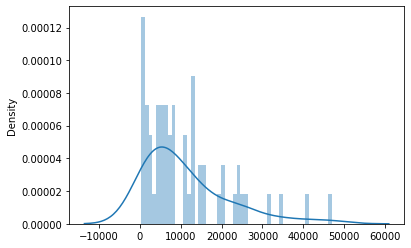

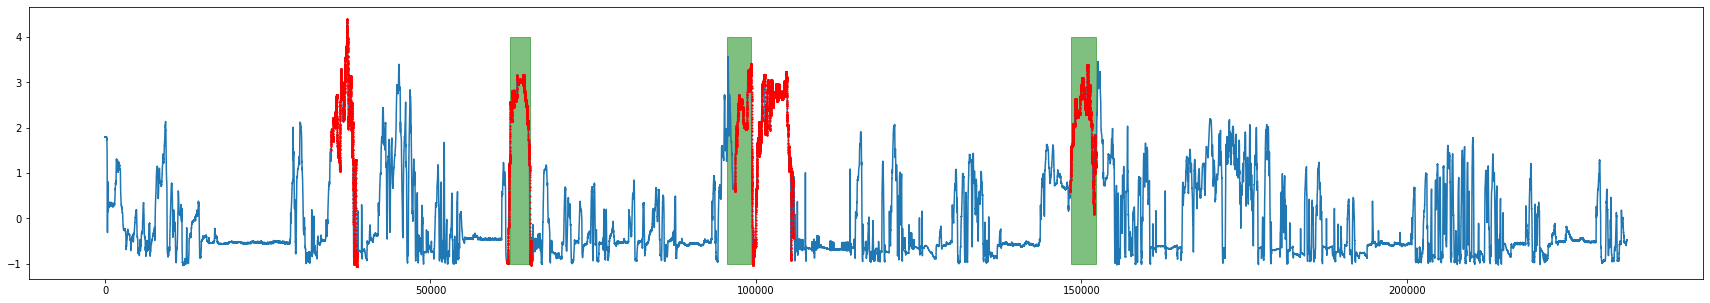

recall : 0.8878504672897196, precision : 0.4328018223234624, accuracy : 0.9467500417017746
time : 36.00880026817322 sec!!!!!!


<Figure size 432x288 with 0 Axes>

In [ ]:
config = easydict.EasyDict({
    "num_epochs" : 10, #500
    "batch_size" : 16, #16 
    "mode" : 'train',
    # "mode" : "test",
    "lr" : 5e-3, 
    "wd" : None,
    "window_size" : 1000,
    "stride" : 250,
    "threshold" : 0.3, # 0.3이나 0.2로 하기
    "seed" : 1004,
    "device" : torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    "small_window" : 9,
    "small_stride" : 5,
    "latent" : 20
})
starttime = time.time()
seed_everything(config.seed)
save_df = pd.DataFrame(columns = ['epochs', 'batch', 'window_size', 'stride', 
                                  'small_window', 'small_stride', 
                                  'recall', 'precision', 'accuracy',
                                  'latent']); df_idx = 0

# tm = time.localtime(time.time())
# string = time.strftime('%Y%m%d_%H%M%S', tm)
# wandb.init(project="Anomaly-Oil", entity="sohyun", name=string, magic=True)

# model = RecurrentAutoencoder(config.window_size, 1, 20).to(config.device) # timesteps, n_features, 128 #원래
for sw in [1000]: # 3, 5, 7, 8, 9, 10
  for ss in [250]: # 3, 4, 5
    if sw <= ss : continue
    # config.small_window = sw
    # config.small_stride = ss
    config.window_size = sw
    config.stride = ss
    print(f"\n< small_window : {sw}, small_stride : {ss} >")
    timesteps2 = math.ceil((config.window_size - config.small_window) / config.small_stride)

    model = RecurrentAutoencoder(config, timesteps2, config.small_window, config.latent).to(config.device)
    model, history = train_model(config, model)
    
    #---# model script save #---#
    m = torch.jit.script(model)
    # torch.jit.save(m, '/content/drive/MyDrive/IITP/sohyun/TimeSeriesAnomaly/codes/for_serve/lstm_ae_script_one.pth')
    
    # MODEL_PATH = './lstm_ae_model.pth'
    MODEL_PATH = '/content/drive/MyDrive/IITP/sohyun/TimeSeriesAnomaly/codes/for_serve/lstm_ae_model_one.pth'
    torch.save(model, MODEL_PATH)
    
    model = torch.load(MODEL_PATH)
    model = model.to(config.device)


    test_dataset, predictions, losses = predict(config, model)
    true_label = get_true_label(test_dataset)
    predictions = np.concatenate(predictions).squeeze()
    sns.distplot(losses, bins=50, kde=True)

    #---# calculate error range #---#
    errors, predictions_vs = reconstruction_errors(test_dataset.x_test, predictions, score_window=config.window_size, step_size=1) #score_window=config.window_size
    error_range = find_anomalies(errors, index=range(len(errors)), anomaly_padding=5)
    print("=== error_range ===\n", error_range)
    prediction = pd.DataFrame(0, index=range(0, len(test_dataset.scaled_test)), columns={'Fu'}) # 빈 행렬
    for i in error_range:
      start = int(i[0])
      end = int(i[1])
      prediction[start:end] = 1

    anomaly_value = get_anomaly_time(test_dataset.scaled_test, prediction['Fu'].values.tolist())
    drawing(anomaly_value, pd.DataFrame(test_dataset.scaled_test))
    recall, precision, accuracy = calculate(pd.DataFrame(true_label), pd.DataFrame(anomaly_value))
    print(f'recall : {recall}, precision : {precision}, accuracy : {accuracy}')
    save_df.loc[df_idx] = [config.num_epochs, config.batch_size, 
                          config.window_size, config.stride, 
                          config.small_window, config.small_stride, 
                          recall, precision, accuracy, config.latent]
    df_idx = df_idx + 1
    # save_df.to_csv(f'./LSTMAE_10061045.csv', header=True, index=False)
endtime = time.time()
print(f"time : {endtime - starttime} sec!!!!!!") # end

In [ ]:
'''loaded_model = torch.jit.load('/content/drive/MyDrive/IITP/sohyun/TimeSeriesAnomaly/codes/for_serve/lstm_ae_script_one.pth')
# loaded_model.state_dict()
book = pd.read_csv("/content/drive/MyDrive/IITP/sohyun/TimeSeriesAnomaly/codes/for_serve/train1516.csv", header=None)
data = torch.Tensor(book.values).reshape(1, 1000).to(config.device)

# loaded_model(data)'''

'loaded_model = torch.jit.load(\'/content/drive/MyDrive/IITP/sohyun/TimeSeriesAnomaly/codes/for_serve/lstm_ae_script_one.pth\')\n# loaded_model.state_dict()\nbook = pd.read_csv("/content/drive/MyDrive/IITP/sohyun/TimeSeriesAnomaly/codes/for_serve/train1516.csv", header=None)\ndata = torch.Tensor(book.values).reshape(1, 1000).to(config.device)\n\n# loaded_model(data)'

In [ ]:
np.nansum(anomaly_value)

43638.4

In [ ]:
def sliding_window(arr):
  start_pt = 0
  total_data = []
  while(True):
    if len(arr) < (start_pt + config.window_size) : break
    data = arr[start_pt:start_pt + config.window_size]
    start_pt += config.stride
    total_data.append(data)
  return np.array(total_data)

av = np.nan_to_num(anomaly_value)
predict_anomaly_binary = [1 if i > 0 else 0 for i in av]

import collections
print("판별된 정상 개수 : ", collections.Counter(predict_anomaly_binary)[0])
print("판별된 anomaly 개수 : ", collections.Counter(predict_anomaly_binary)[1])

predict_anomaly_binary_sliding = sliding_window(predict_anomaly_binary)
predict_anomaly_binary_sliding_set = np.sum(predict_anomaly_binary_sliding, axis=1)

# test_dataset = MyDataset(config, mode="test")
scaler = StandardScaler()
Fu_22_abnormal_10_scaled = scaler.fit_transform(Fu_22_abnormal_10.reshape(-1, 1)).squeeze()

test_dataset = sliding_window(Fu_22_abnormal_10_scaled)
difference = test_dataset - predictions
difference_set = np.sum(difference, axis=1)


판별된 정상 개수 :  214540
판별된 anomaly 개수 :  19263


In [ ]:
predict_anomaly_binary_sliding_set.shape
# difference_set

(932,)

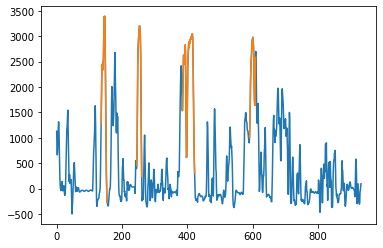

In [ ]:
pp = [np.nan if predict_anomaly_binary_sliding_set[i] == 0 else difference_set[i] for i in range(len(predict_anomaly_binary_sliding_set))]
arr_true = [np.nan if predict_anomaly_binary_sliding_set[i] > 0 else difference_set[i] for i in range(len(predict_anomaly_binary_sliding_set))]

plt.plot(difference_set)
plt.plot(pp)

In [ ]:
arr_ano = [i for i in pp if i is not np.nan] # 판별된 anomaly만의 array
arr_no = [i for i in arr_true if i is not np.nan]
len(arr_true)

In [ ]:
difference_set[np.where(difference_set > 1500)]
np.where(difference_set > 1500)

(array([ 34, 118, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 168, 169, 170, 171, 175, 176, 177, 178, 179, 180,
        181, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
        377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389,
        390, 391, 392, 393, 394, 395, 400, 401, 402, 403, 404, 405, 406,
        407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 483,
        592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604,
        605, 606, 607, 608, 609, 610, 611, 615, 616, 675, 676, 677, 678,
        679, 688, 689, 690, 691, 692, 693]),)

In [ ]:
difference_set[603]

2611.296049632526

(array([ 2.,  4.,  4.,  5.,  6.,  9.,  6., 21., 27.,  9.]),
 array([-273.75232481,   92.79658868,  459.34550218,  825.89441567,
        1192.44332917, 1558.99224266, 1925.54115616, 2292.09006965,
        2658.63898315, 3025.18789664, 3391.73681014]),
 <a list of 10 Patch objects>)

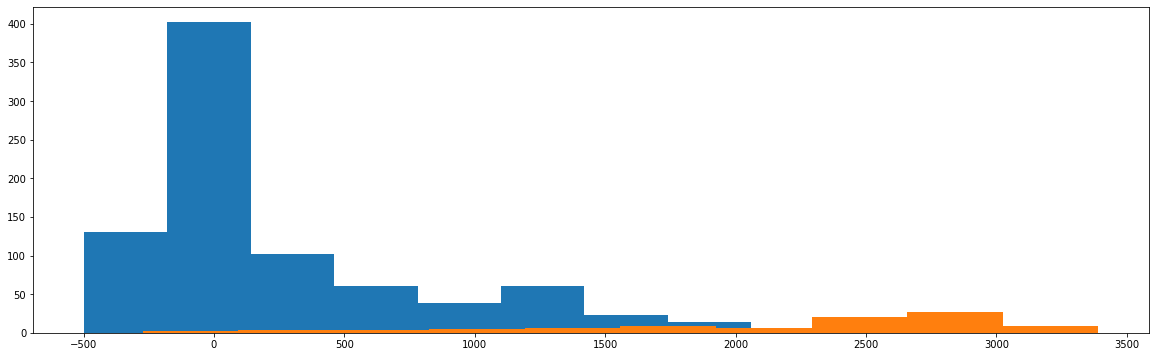

In [ ]:
# plt.hist(arr_ano)
plt.figure(figsize=(20,6))
plt.hist(arr_no)
plt.hist(arr_ano)

(array([134., 400., 104.,  57.,  39.,  59.,  23.,  14.,   2.,   7.]),
 array([-478.71700853, -146.78830725,  185.14039402,  517.0690953 ,
         848.99779657, 1180.92649784, 1512.85519912, 1844.78390039,
        2176.71260166, 2508.64130294, 2840.57000421]),
 <a list of 10 Patch objects>)

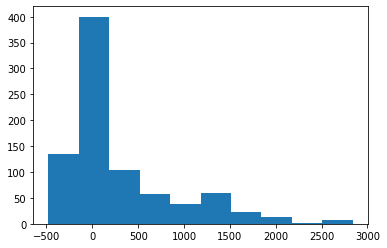

In [ ]:
plt.hist(arr_no)

In [ ]:
predictions.shape, test_dataset.x_test.shape # same

(932, 1000)

In [ ]:
test_dataset = MyDataset(config, mode="test")
difference = test_dataset.x_test - predictions
np.sum(difference, axis=1).shape

(932,)

In [ ]:
raise

RuntimeError: ignored

In [ ]:
def sliding_window(arr):
  start_pt = 0
  total_data = []
  while(True):
    if len(arr) < (start_pt + config.window_size) : break
    data = arr[start_pt:start_pt + config.window_size]
    start_pt += config.stride
    total_data.append(data)
  return np.array(total_data)

true_slide = sliding_window(true_label)

# train_dataset = MyDataset(config, mode="train")
# train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=False, drop_last=True) # drop_last=True
# val_dataset = MyDataset(config, mode="val")
# val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, drop_last=True)
# test_dataset = MyDataset(config, mode="test")
# test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, drop_last=True) # drop_last=True

'''
total_num = train_loader.dataset.x_train.shape[0]
print(total_num)
for i in range(total_num):
  df = pd.DataFrame(train_loader.dataset.x_train[i])
  # df.to_csv(f"/content/drive/MyDrive/IITP/save_files/train{i}.csv", index=False, header=False)
  

total_num = val_loader.dataset.x_val.shape[0]
for i in range(total_num):
  df = pd.DataFrame(val_loader.dataset.x_val[i])
  # df.to_csv(f"/content/drive/MyDrive/IITP/save_files/val{i}.csv", index=False, header=False)
'''

anomaly_idx = []
for idx, i in enumerate(true_slide):
  if sum(i) > 0 : 
    anomaly_idx.append(idx)

# total_num = test_loader.dataset.x_test.shape[0]
test_ = sliding_window(Fu_22_abnormal_10)
total_num = test_.shape[0]

for i in range(total_num):
  flag = 0
  if i in anomaly_idx:
    flag = 1    
    print(f"{i}!!!")

    df = pd.DataFrame(test_[i])
    df.to_csv(f"/content/drive/MyDrive/IITP/sohyun/TimeSeriesAnomaly/codes/for_serve/test_dataset/test{i}_{flag}.csv", index=False, header=False)


In [ ]:
anomaly_idx

In [ ]:
test_dataset = MyDataset(config, mode="test")
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, drop_last=True) # drop_last=True
total_num = test_loader.dataset.x_test.shape[0]
total_num

In [ ]:
def sliding_window(arr):
  start_pt = 0
  total_data = []
  while(True):
    if len(arr) < (start_pt + config.window_size) : break
    data = arr[start_pt:start_pt + config.window_size]
    start_pt += config.stride
    total_data.append(data)
  return np.array(total_data)

hi = sliding_window(true_label)

In [ ]:
anomaly_idx = []
for idx, i in enumerate(hi):
  if sum(i) > 0 : 
    print(idx, sum(i))
    anomaly_idx.append(idx)

In [ ]:
sliding_window(Fu_22_abnormal_10).shape

(932, 1000)